In [75]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Baseline Imports
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Random Forest Imports
from sklearn.ensemble import RandomForestRegressor

# Decision Tree Imports
from sklearn.tree import DecisionTreeRegressor

# K-fold Validation Imports
from sklearn.model_selection import KFold, cross_val_score

In [76]:
data = pd.read_csv("crimedata2.csv", encoding="ISO-8859-1")
data = data.replace('?', np.nan)
data = data.dropna(subset=['ViolentCrimesPerPop'])

columns = ['agePct12t29', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'population', 'racepctblack',
              'racePctWhite', 'racePctAsian', 'racePctHisp', 'medIncome', 'medFamInc', 'perCapInc', 'PctSpeakEnglOnly',
              'PctNotSpeakEnglWell', 'ViolentCrimesPerPop']
df = data[columns].astype(float)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df

print(df.ViolentCrimesPerPop.isna().sum())


0


In [77]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

catData = df
# effectively binning the violent crimes per population into x bins based on the distribution
n = catData['ViolentCrimesPerPop'].quantile([0, 0.33, 0.66, 1]).values
binLabels = ['low', 'medium', 'high']

catData['ViolentCrimesCat'] = pd.cut(catData['ViolentCrimesPerPop'], bins=n, labels = binLabels)
# drop 'nan' from the new categorical column
catData = catData.dropna(subset=['ViolentCrimesCat'])
catData['ViolentCrimesCat'].value_counts()
catData['ViolentCrimesCat'] = catData['ViolentCrimesCat'].astype(str)
X = catData.drop(columns=['ViolentCrimesPerPop', 'ViolentCrimesCat'])
y = catData['ViolentCrimesCat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# print bin counts
print(catData['ViolentCrimesCat'].value_counts())

ViolentCrimesCat
high      678
medium    658
low       657
Name: count, dtype: int64


/var/folders/zp/xzl97jrj4bgfcnnjjm_hk2dc0000gn/T/ipykernel_73065/1301249743.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catData['ViolentCrimesCat'] = catData['ViolentCrimesCat'].astype(str)


Cross-Validation Scores for each fold: [0.655      0.74       0.705      0.68844221 0.65326633 0.68341709
 0.72361809 0.67336683 0.63316583 0.66834171]
Average Cross-Validation Score: 0.6823618090452261
Accuracy: 0.6791979949874687
Precision: 0.6715683366156727
Recall: 0.6791979949874687
F1-Score: 0.6740753336177953
ROC-AUC: 0.8400566640837605


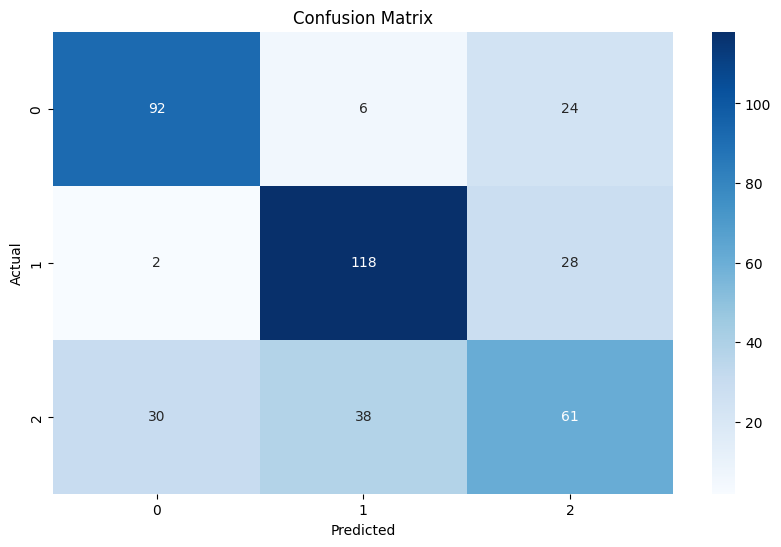

In [78]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)

k = 10
cv_scores = cross_val_score(rf, X, y, cv=k, scoring='accuracy')
print(f"Cross-Validation Scores for each fold: {cv_scores}")
print(f"Average Cross-Validation Score: {np.mean(cv_scores)}")

# Evaluate model performance on the test set
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

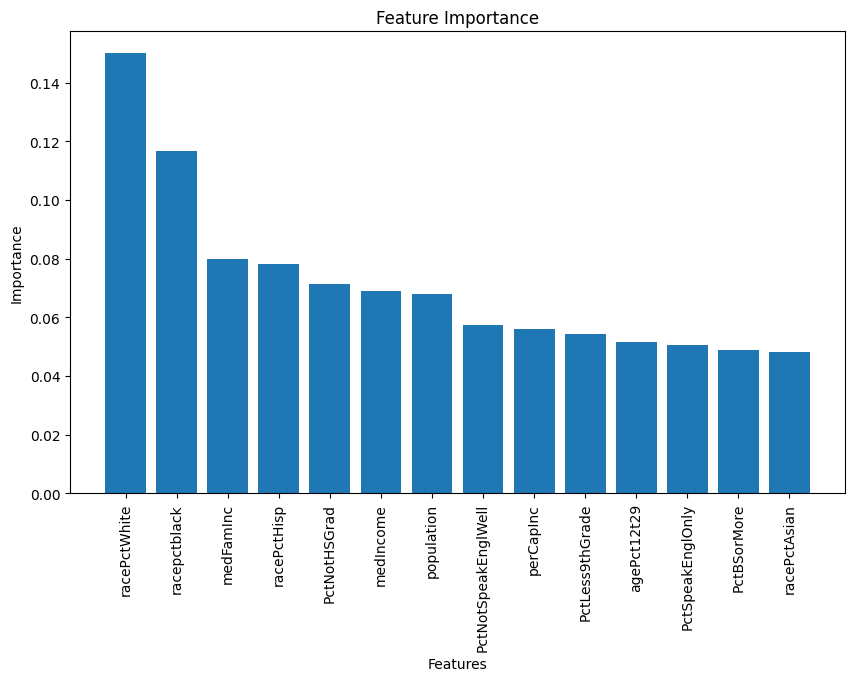

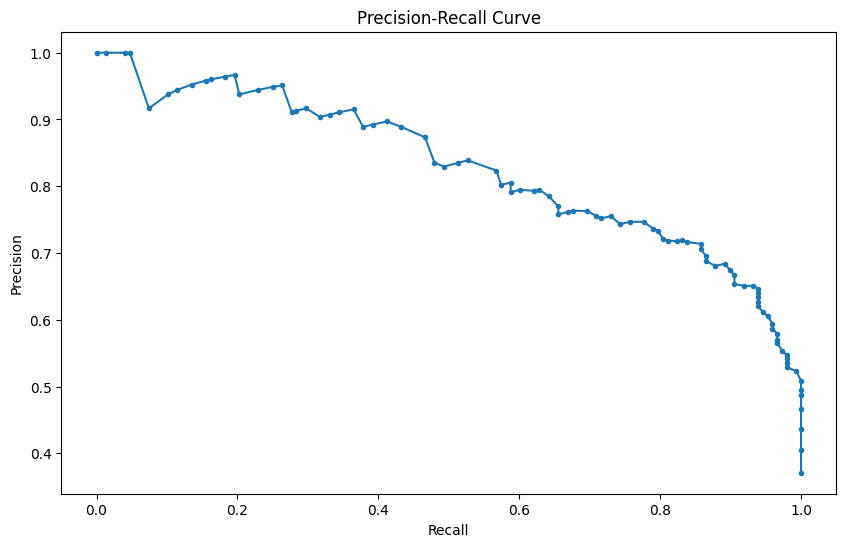

AUC: 0.8287620648120056


In [ ]:
# feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

# precistion recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

precision, recall, thresholds = precision_recall_curve(y_test, rf.predict_proba(X_test)[:, 2])
auc_score = auc(recall, precision)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
print(f"AUC: {auc_score}")